<a href="https://colab.research.google.com/github/shramkoartem/TableGraphRCNN/blob/dev/notebooks/Table_Detection_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://github.com/sgrpanchal31/table-detection-dataset/archive/master.zip
# https://github.com/sgrpanchal31/table-detection-dataset - source

In [2]:
!wget https://github.com/sgrpanchal31/table-detection-dataset/archive/master.zip
!ls

--2021-01-25 20:08:44--  https://github.com/sgrpanchal31/table-detection-dataset/archive/master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/sgrpanchal31/table-detection-dataset/zip/master [following]
--2021-01-25 20:08:44--  https://codeload.github.com/sgrpanchal31/table-detection-dataset/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip.1’

master.zip.1            [       <=>          ]  29.74M  23.6MB/s    in 1.3s    

2021-01-25 20:08:45 (23.6 MB/s) - ‘master.zip.1’ saved [31182443]

master.zip  master.zip.1  sample_data  table-detection-dataset-master


In [3]:
!unzip -q master.zip
!mv table-detection-dataset-master data

replace table-detection-dataset-master/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [100]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from skimage import io, transform
import skimage

plt.ion()


In [101]:
IMG_PATH = "data/images/"

train_bbox_df = pd.read_csv("data/train.csv", header=None)
val_bbox_df = pd.read_csv("data/val.csv", header=None)

print(len(os.listdir(IMG_PATH)))
print(len(train_bbox_df))
print(len(val_bbox_df))

403
418
100


In [102]:
train_bbox_df.iloc[:5,1:-1]

,1,2,3,4
0,770,946,2070,2973
1,270,1653,2280,2580
2,303,343,2273,2953
3,664,1782,1814,2076
4,704,432,1744,1552


In [103]:
n =5 

img_name = train_bbox_df.iloc[n,0]
bbox = train_bbox_df.iloc[n,1:-1]
bbox = np.asarray(bbox)
print(bbox)


[682 1740 1800 2440]


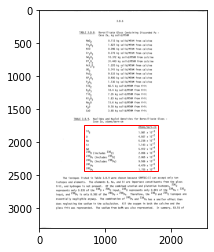

In [104]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image


def show_bbox(image, bbox):
  """ Show image with bbox """
  plt.imshow(image)

  # draw rectangle
  xmin, ymin, xmax, ymax = bbox
  w = xmax - xmin
  h = ymax - ymin

  rect = Rectangle((xmin, ymin), w, h,
                   linewidth=1,edgecolor='r',
                   facecolor='none')
  ax = plt.gca()
  ax.add_patch(rect)
  plt.pause(0.001)


im = Image.open(os.path.join(IMG_PATH, img_name))
show_bbox(im, bbox)



In [105]:
io.imread(os.path.join(IMG_PATH, img_name))

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

PIL.PngImagePlugin.PngImageFile

# Dataset

In [106]:
class TableDataset(Dataset):
  """ Table Detection Dataset """
  def __init__(self, img_path, csv_file, transforms=False):
    """        
    Args:
      img_path (string): Directory containing images
      csv_file (string): Path to the csv file containig annotations
      transform (callable, optional): Transforms to be applied
    """
    self.img_path = img_path
    self.bbox_frame = pd.read_csv(csv_file, header=None)
    self.transforms = transforms

  def __len__(self):
    return len(self.bbox_frame)

  def __getitem__(self, idx):
    """
    Returns sample at index 'idx'
    Returns:
      {"image": image, "bbox": bbox} (dict)
    """
    if torch.is_tensor(idx):
      idx = idx.tolist()

    # load image
    img_name = self.bbox_frame.iloc[idx,0]
    image = skimage.io.imread(os.path.join(self.img_path, img_name))

    # load coordinates of a bounding box
    bbox = self.bbox_frame.iloc[idx,1:-1]
    bbox = np.array(bbox)
    sample = {'image': image, "bbox": bbox}

    return sample




KeyError: ignored

0 (3300, 2544) (4,)


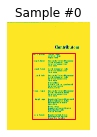

1 (3300, 2544) (4,)


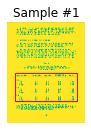

2 (3300, 2544) (4,)


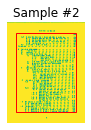

3 (3300, 2560) (4,)


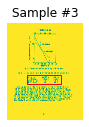

In [108]:
# test

ds = TableDataset(img_path = IMG_PATH, csv_file="data/train.csv")

fig = plt.figure()

for i in range(len(ds)):
  sample = ds[i]

  print(i, sample["image"].shape, sample["bbox"].shape)

  ax = plt.subplot(1,4, i+1)
  plt.tight_layout()
  ax.set_title(f"Sample #{i}")
  ax.axis("off")
  show_bbox(**sample)

  if i ==3:
    plt.show()
    break

In [109]:
sample["bbox"]

array([664, 1782, 1814, 2076], dtype=object)

# Transforms

In [90]:
import skimage

class Rescale(object):
  def __init__(self, output_size):
    assert isinstance(output_size, tuple)
    self.output_size = output_size

  def __call__(self, sample):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    image, bbox = sample['image'], sample['bbox']
    xmin, ymin, xmax, ymax = bbox.tolist()
    h, w = image.shape[:2]

    new_h, new_w = self.output_size

    image = skimage.transform.resize(image, (new_h, new_w))
    bbox = bbox * [new_w / w, new_h / h,
                             new_w / w, new_h / h]

    resized_sample = {'image' : image, 'bbox' : bbox}
    return resized_sample




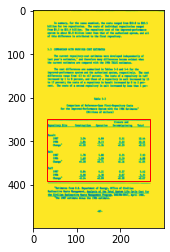

In [93]:
scale = Rescale((500,300))

imtest = scale(ds[1])

show_bbox(**imtest)

In [80]:
ds[1]["bbox"].tolist()

[270, 1653, 2280, 2580]

In [95]:
imtest["image"].shape

(500, 300)